# Multi-Armed Bandit Game
## Andrew Yeh

In [1]:
import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython.core.debugger import set_trace

In [93]:
def print_houses():
    # Prints out current state of houses and (sample) average reward
    for i in range(len(houses)):
        if(houses[i][1] == 1):
            print("House ",i,": ",np.round(houses[i][0],2))
    
def choose_house(i):
    # Chooses house i and adds to total rewards. 
    # Marks house as revealed
    # Prints out house award and total award
    houses[i][1] = 1
    reward = houses[i][0]
    return(reward)
    
    
def generate_houses_normal(mean = 0, std = 10, n = 1000):
    means = np.random.normal(mean, std, n)
    houses = [[i,0] for i in means]
    
    return(houses)

Factors of interest:
* How different are the rewards?

If they aren't that different, you don't need to try that much. If they are very different, you need to try more.

* How many houses are there?

There is a trying phase and an exploitation phase. At first glance, I think we want to find the point such that 1 more house tried as a percent of total houses is just less than 1 more try as a percent of tries, i.e. a given try decreases our "exploitation time" as a percent more than it increases our chance of finding the true maximum.

* Is the reward for a given house fixed or a random variable?

If it's a random variable, do we know the distribution? I'm just going to make it normally distributed for this game.

In [101]:
def play_game(tries, strategy = "manual", threshold = 0.5):
    # Print information about game:
    
    
    # Play game and print status reports:
    rewards = np.zeros(tries)
    for turn in range(tries):
        
        revealed_houses = [i[0]*i[1] for i in houses]
        
        if strategy == "manual":
            choice = input()
            # Clear output every try:
            clear_output()

            print("Try Number:", turn+1)
            print("Your choice:", choice)
            print("Total reward:",np.round(total_rewards[turn], 2),"\n")
            print_houses()
        else:
            choice = strategy(revealed_houses, turn, tries, threshold = threshold)
        
        if choice == "max":
            choice = revealed_houses.index(max(revealed_houses))
        if choice == "explore":
            unexplored = np.where(np.array(revealed_houses) == 0)[0]
            choice = np.random.choice(unexplored)
        
        rewards[turn] = choose_house(choice)        
    
    # Out of loop
    total_rewards = np.cumsum(rewards)
    
    # print("\n Game finished!")
    return(total_rewards)
    

In [174]:
def plot_strategy_run(total_rewards, label):
    plt.plot(range(len(total_rewards)), total_rewards, label = label)
    plt.xlabel("Tries")
    plt.ylabel("Reward")

In [193]:
def plot_strategy_runs(strategy_runs, thresholds):
    for i in range(len(learn_p_strategy)):
        plot_strategy_run(learn_p_strategy[i], label = thresholds[i])

    plt.legend(loc = "upper left")

In [200]:
def plot_strategy_results(strategy_runs, thresholds, label):
    results = [i[-1] for i in strategy_runs]
    
    plt.plot(thresholds, results, label = label)
    plt.xlabel("Threshold")
    plt.ylabel("Reward")
    plt.legend(loc = "upper right")

In [213]:
def find_average_run(strategy, threshold, n = 100):
    all_runs = [play_game(100, strategy = strategy, threshold = threshold) for i in range(n)]
    average_run = np.mean(all_runs, axis = 0)
    
    return(average_run)

Todo: 
1. Make line graph of average result over different thresholds for same strategy. Different colored lines signify different strategies.

In [203]:
def learn_p_then_exploit(revealed_houses, try_number, total_tries, threshold = 0.5):
    # set_trace()
    if 0 not in revealed_houses:
        return("max")
    
    if try_number/total_tries < threshold:
        return("explore")
    
    return("max")

In [204]:
def randomly_explore_p(revealed_houses, try_number, total_tries, threshold = 0.1):
    # set_trace()
    if 0 not in revealed_houses:
        return("max")
    
    if np.random.uniform(0, 1) < threshold:
        return("explore")
    
    return("max")

In [214]:
houses = generate_houses_normal(100,40,1000)
thresholds = [i/10 for i in range(10)]

learn_p_strategy = [find_average_run(strategy = learn_p_then_exploit, threshold = i) for i in thresholds]

In [219]:
thresholds

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

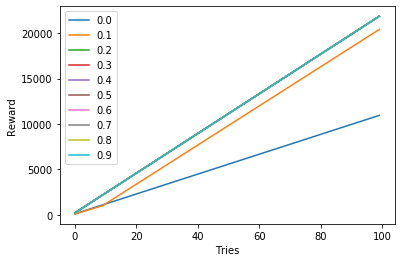

In [215]:
plot_strategy_runs(learn_p_strategy, thresholds = thresholds)

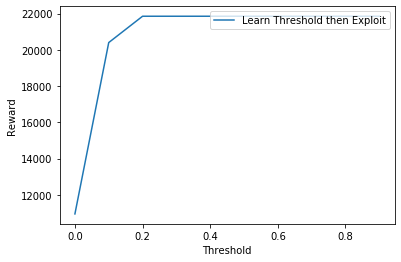

In [216]:
plot_strategy_results(learn_p_strategy, thresholds = thresholds, label = "Learn Threshold then Exploit")

Mathematically, here is one way to think about the optimal solution to the problem:
\begin{align*}
i&: \text{Index for current try}\\
t&: \text{Total number of tries}\\
D_i&: \text{Reward for door on try i}\\
D_{max}&: \text{Maximum reward among explored doors}\\
\mu&: \text{sample mean}\\
\sigma&: \text{sample standard deviation}\\
\end{align*}
We're interested in:
\begin{align*}
\text{Expected gain from exploration} &= E(D_i - D_{max}|D_i > D_{max})\times P(D_i > D_{max})\times (t-i)\\
\text{Expected loss from exploration} &= (D_{max} - E(D_i))\times P(D_i < D_{max})\\
&= (D_{max} - \mu)\times (1 - P(D_i > D_{max}))\\
\end{align*}
If the expected gain from exploration is larger than the expected loss from exploration, then we should proceed. If not, we exploit.

We can either assume a distribution (uniform/normal) or use a kernel smoother to empirically estimate a pdf $f_D$ of the distribution of door rewards. This will give us an estimate for:
\begin{align*}
P(D_i > D_{max}) = \int_{D_{max}}^{\infty}f_D(x)dx
\end{align*}
To calculate $E(D_i - D_{max}|D_i > D_{max})$:
\begin{align*}
E(D_i - D_{max}|D_i > D_{max}) &= \int_{D_{max}}^{\infty}(x - D_{max})f_{D}(x)dx
\end{align*}

The main problem with this is that Bayesian methods to estimate the density function will likely not capture the max.